In this notebook, I will have to implement the diffusion model from scratch and will deep dive that how the different peices in a diffuser model work together.
In summary in this notebook I will look into the:
1) The process of adding the noise called corruption process.
2) What is UNet, how to implement a bare minimal version of UNet from scratch.
3) Training the model
4) Sampling theory

The above-mentioned points will then be compared to the version provided by the diffuser library mainly:
1)  How to improve our bare minimal UNet.
2) The noise schedule used in DDPM paper with our own version.
3) Difference of the training process.
4) Sampling methodologies



In [1]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt

Using device: cuda


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

##### Dataset
For the given case I will use the small mnist dataset containing only digits provided by torchvision.


In [2]:
dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True,
                                     transform=torchvision.transforms.ToTensor())

100%|██████████| 9912422/9912422 [00:03<00:00, 3195283.16it/s]


Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 1208263.78it/s]


Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 1889412.29it/s]


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18247632.92it/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw


I will have to create a batch size of 8 to use the less possible resources.


In [3]:
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

The shape or the size of the image is of 28px by 28px of drawing of digits.


Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([0, 3, 3, 6, 8, 4, 3, 9])


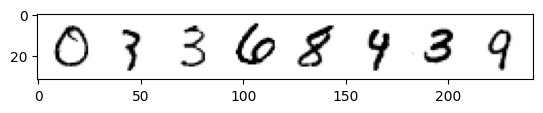

In [4]:
x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys');

#### Noise Addition: The corruption process
The core of the diffuser lies in the addition of noise, barely speaking. 

First we create a random input and then we specify the amount of noise to be added to the input as:

`noise = torch.rand_like(x)` 

`noisy_x =  (1-amount)*x + amount*noise`

Here if we specify the amount as to be `amount = 0` we will get exactly the same input as output without any change. If we try to increase the noise amount upto 1, we will get the back the same noise with the no trace of the input x. This way, we can mix the noise ranging from 0 to 1 in a similar fashion.

As the noise is increasing from 0 to 1, the data becomes like the random noise. 

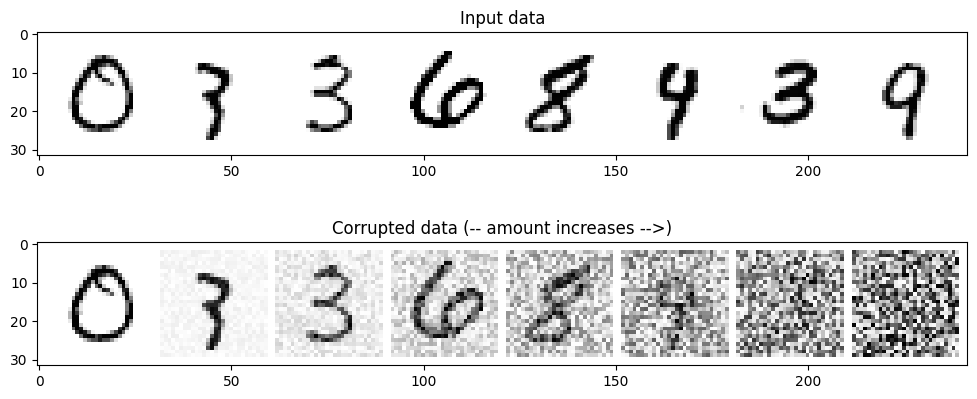

In [6]:
def corrupt(x, amount):
    """Corrupt the input `x` by mixing it with noise according to `amount`"""
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1, 1, 1)  # Sort shape so broadcasting works
    return x * (1 - amount) + noise * amount


# Plotting the input data
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

# Adding noise
amount = torch.linspace(0, 1, x.shape[0])  # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Plotting the noised version
axs[1].set_title('Corrupted data (-- amount increases -->)')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap='Greys');

### The UNet
The optimal model for diffuser is to take a 28px noise image and output predicted image of same shape. The model used in the diffuser library is called UNet. 
The UNet was originally invented for [Originally invented for segmentation tasks in medical imagery](https://arxiv.org/abs/1505.04597)
 a UNet consists of a ` constricting path ` through which the data at first compressed down and a `expanding path` through which it expands back up to the original dimension similar like autoencoder, however, UNet have a feature of skip connections, which allows for the flow of information and gradients at various levels.
 
A few UNet consists of complex blocking at each stage, but for our case of minimal example, is consists of just one channel of image. The image is then passed through the three convolutional layers on the down path and three on the up path, with skip connections between the down and up layers. Instead of using the learnable layers of complex UNets, I will stick to use the max pooling for downsampling and `nn.UpSample` for upsampling. Below is the code for the basic UNet.

In [7]:
class BasicUNet(nn.Module):
    """A minimal UNet implementation."""

    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down_layers = torch.nn.ModuleList([
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
        ])
        self.up_layers = torch.nn.ModuleList([
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, out_channels, kernel_size=5, padding=2),
        ])
        self.act = nn.SiLU()  # The activation function
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x))  # Through the layer and the activation function
            if i < 2:  # For all but the third (final) down layer:
                h.append(x)  # Storing output for skip connection
                x = self.downscale(x)  # Downscale ready for the next layer

        for i, l in enumerate(self.up_layers):
            if i > 0:  # For all except the first up layer
                x = self.upscale(x)  # Upscale
                x += h.pop()  # Fetching stored output (skip connection)
            x = self.act(l(x))  # Through the layer and the activation function

        return x

Below is the verification of that the output is of the same shape as of the input.

In [8]:
net = BasicUNet()
x = torch.rand(8, 1, 28, 28)
net(x).shape

torch.Size([8, 1, 28, 28])

The UNet network has more than 300000 parameters.

In [9]:
sum([p.numel() for p in net.parameters()])

309057

We can mess by changing the channels at the different layers.

#### Training the UNet
Roughly speaking, what is the purpose of the model ? There are various arguments for this, but for this minimal case, the model has the one task, with the corrupted noisy_x, the model should provide its optimal guess for the original x, that is how the original image will look like. The model is evaluated and then we will compared it to the actual value via the mean squared error as a loss.


For training purposes  we have to:
- Get a batch of data
- Corrupt it by the random amount of noise
- Feed it through the UNet model.
- Compared the model`s prediction with the clean images for the calculation of the loss
- Update the model parameters via back.propagation
 

Finished epoch 0. Average loss for this epoch: 0.025176
Finished epoch 1. Average loss for this epoch: 0.019933
Finished epoch 2. Average loss for this epoch: 0.018428


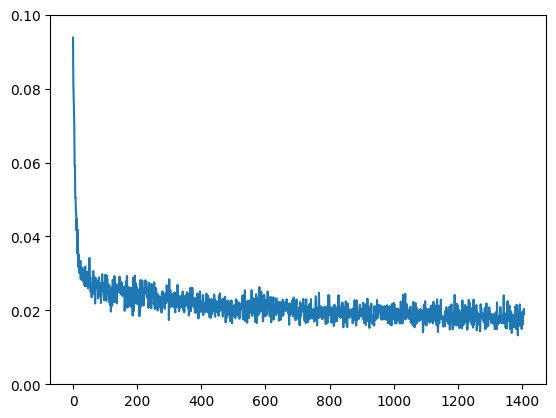

In [10]:
# Dataloader (you can mess with batch size)
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
# How many runs through the data should we do?
n_epochs = 3
# Create the network
net = BasicUNet()
net.to(device)
# Our loss function
loss_fn = nn.MSELoss()
# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3)
# Keeping a record of the losses for later viewing
losses = []
# The training loop
for epoch in range(n_epochs):
    for x, y in train_dataloader:
        # Get some data and prepare the corrupted version
        x = x.to(device)  # Data on the GPU
        noise_amount = torch.rand(x.shape[0]).to(device)  # Pick random noise amounts
        noisy_x = corrupt(x, noise_amount)  # Create our noisy x
        # Get the model prediction
        pred = net(noisy_x)
        # Calculate the loss
        loss = loss_fn(pred, x)  # How close is the output to the true 'clean' x?
        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()
        # Store the loss for later
        losses.append(loss.item())
    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader):]) / len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

# View the loss curve
plt.plot(losses)
plt.ylim(0, 0.1);

To visualize the model predictions at each stage, we will take a batch of data, try to add the noise to the image i.e corrupting it with varying amount ranging from 0 to 1, and visualize the model predictions.
The lower the amounts of the predictions the pretty good its, but as the amount of noise is getting very high, there is a less room for the model to work with and when the amount of noise=1 we get the blurriness.

#### Sampling
If we start from the random noise, and then if we have to move only a small amount of noise toward the model prediction, i.e 20%. At the given stage we have a hint of the structure of the image, we can feed it into the model to get a new prediction, in a hope that the new predicted model will be slightly better than the previous one, and we can take another small step with the new, prediction.

The iteration process is continued till we get an image as an output. In the given case I will use the number of steps as 5.
We can visualize the model, input (x) on the left and the predicted one on the right at each stage. The model starts its prediction at the step first, however we have to move the x part a way there. Over the few steps, the structures appear and refined, till we get our final output.

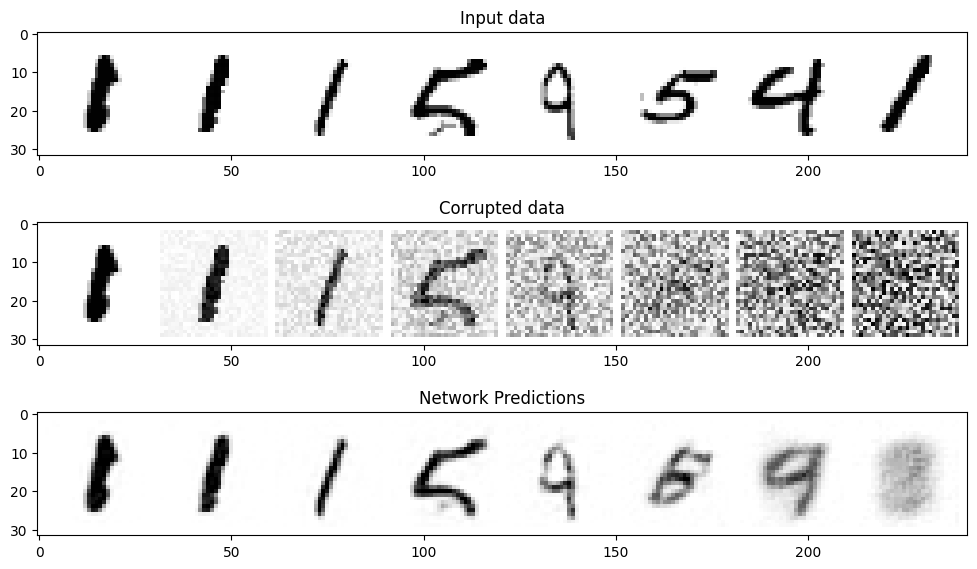

In [11]:

# Fetch some data
x, y = next(iter(train_dataloader))
x = x[:8]  # Only using the first 8 for easy plotting

# Corrupt with a range of amounts
amount = torch.linspace(0, 1, x.shape[0])  # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Get the model predictions
with torch.no_grad():
    preds = net(noised_x.to(device)).detach().cpu()

# Plot
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0].clip(0, 1), cmap='Greys')
axs[1].set_title('Corrupted data')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0].clip(0, 1), cmap='Greys')
axs[2].set_title('Network Predictions')
axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0, 1), cmap='Greys');

We can keep the iteration further in a hope that we will get better images than the existed ones. 

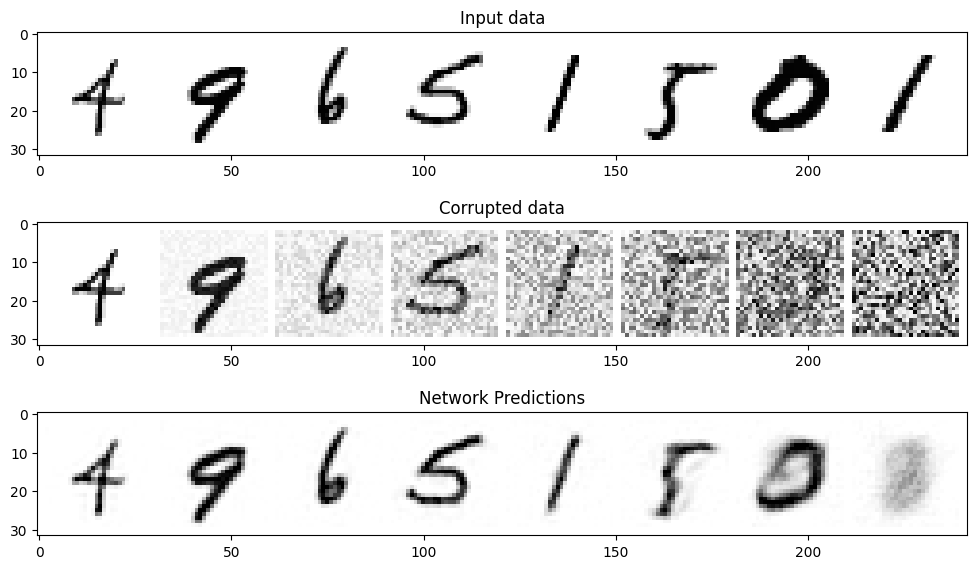

In [12]:
# Fetch some data
x, y = next(iter(train_dataloader))
x = x[:8]  # Only using the first 8 for easy plotting

# Corrupt with a range of amounts
amount = torch.linspace(0, 1, x.shape[0])  # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Get the model predictions
with torch.no_grad():
    preds = net(noised_x.to(device)).detach().cpu()

# Plot
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0].clip(0, 1), cmap='Greys')
axs[1].set_title('Corrupted data')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0].clip(0, 1), cmap='Greys')
axs[2].set_title('Network Predictions')
axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0, 1), cmap='Greys');

    Not great result, however, the digits are somehow recognizable. By increasing the training for longer lets say 10-20 epochs, tweaking the model config, learning rate, optimizer and so on, we can expect better images than the present.

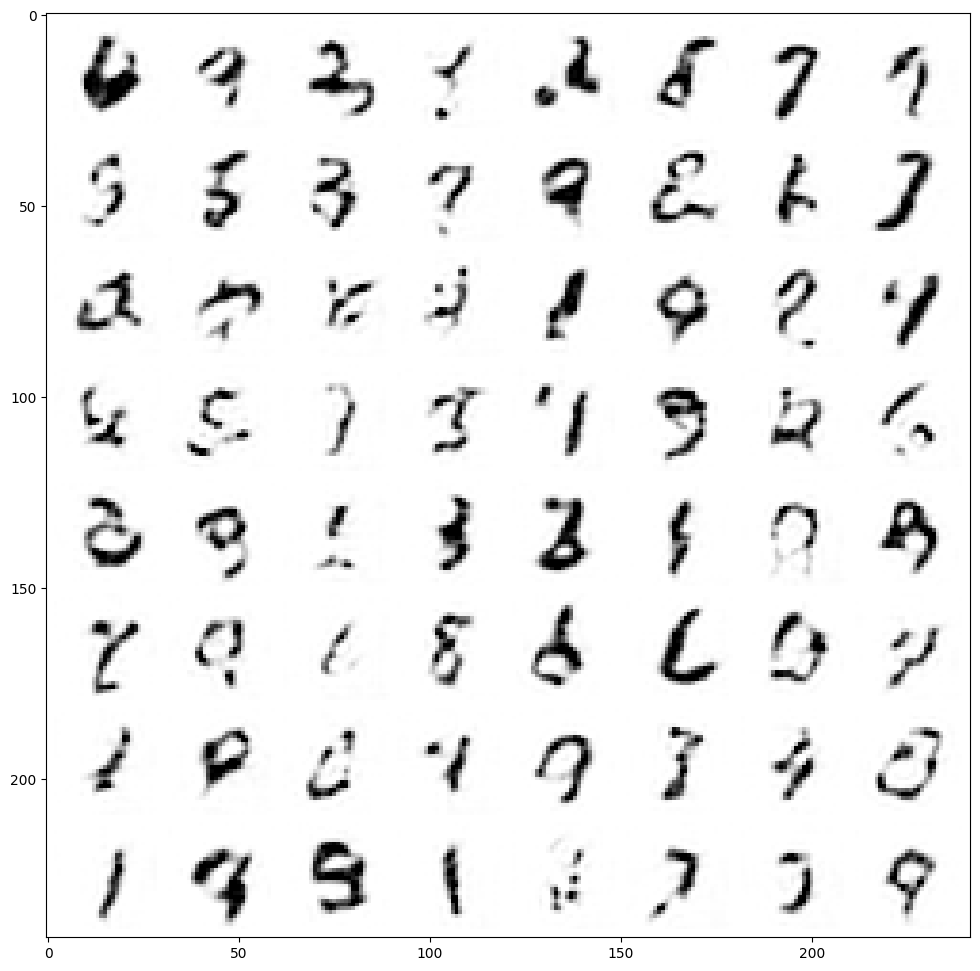

In [14]:
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
    noise_amount = torch.ones((x.shape[0],)).to(device) * (1 - (i / n_steps))  # Starting high going low
    with torch.no_grad():
        pred = net(x)
    mix_factor = 1 / (n_steps - i)
    x = x * (1 - mix_factor) + pred * mix_factor
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys');

### Comparison to DDPM
How our own implemented model is different from the pre-trained one which I used in the second notebook of the ongoing chapter.
We will observe that:
- The diffusers `UNet2DModel` is advanced than our BasicUNet.
- The corruption process of the diffusers is handled differently than our one.
- In our case we used the model prediction than for denoising the image, wherein the diffusers uses the model for predicting the noise.
- The model is conditioned on the amount of different noise present, and it's coupled with the given timestamp, where the t is used as an extra argument to the forward method of the model. 
- The diffusers uses the different sampling strategies, which should provide better results than our own implemented one.

### Diffusers UNet
The diffusers UNet is different from the implemented one mainly:
- GroupNorm applies to the group normalization to the input of each block.
- The dropout layers are for smoother training
- There are number of resnet per block (if layers_per_block isn`t set to 1)
- Attention is happened at the lower resolution blocks
- Conditioning is coupled with the timestamp
- Downsampling and upsampling blocks are provided with the learnable parameters


The below code provide the  `UNet2DModel` of diffusers models.
 


In [15]:
model = UNet2DModel(
    sample_size=28,  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64),  # Roughly matching our basic unet example
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",  # a regular ResNet upsampling block
    ),
)
print(model)

UNet2DModel(
  (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): LoRACompatibleLinear(in_features=32, out_features=128, bias=True)
    (act): SiLU()
    (linear_2): LoRACompatibleLinear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
          (conv1): LoRACompatibleConv(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): LoRACompatibleLinear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): LoRACompatibleConv(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleLis

In [16]:
sum([p.numel() for p in model.parameters()])  # 1.7M vs the ~309k parameters of the BasicUNet

1707009

We can replicate the above steps as we did for our mentioned minimal basic `UNet`. Here along with the input image x we also have to pass the timestamp parameters of the forward method of the `UNet2DModel` for conditioning.

/home/sajjad/PycharmProjects/my/.venv/lib/python3.10/site-packages/diffusers/models/attention_processor.py:1244: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ../aten/src/ATen/native/transformers/hip/sdp_utils.cpp:264.)
  hidden_states = F.scaled_dot_product_attention(
/home/sajjad/PycharmProjects/my/.venv/lib/python3.10/site-packages/diffusers/models/attention_processor.py:1244: UserWarning: 1Torch was not compiled with memory efficient attention. (Triggered internally at ../aten/src/ATen/native/transformers/hip/sdp_utils.cpp:320.)
  hidden_states = F.scaled_dot_product_attention(


Finished epoch 0. Average loss for this epoch: 0.018365
Finished epoch 1. Average loss for this epoch: 0.012959
Finished epoch 2. Average loss for this epoch: 0.011557


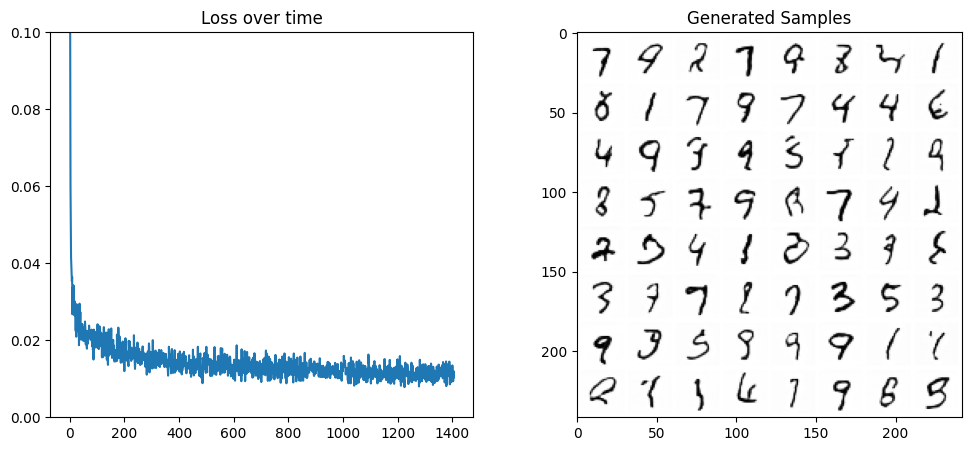

In [17]:
# Dataloader (you can mess with batch size)
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# How many runs through the data should we do?
n_epochs = 3

# Create the network
net = UNet2DModel(
    sample_size=28,  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64),  # Roughly matching our basic unet example
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",  # a regular ResNet upsampling block
    ),
)  
net.to(device)

# Our loss finction
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):

    for x, y in train_dataloader:
        # Get some data and prepare the corrupted version
        x = x.to(device)  # Data on the GPU
        noise_amount = torch.rand(x.shape[0]).to(device)  # Pick random noise amounts
        noisy_x = corrupt(x, noise_amount)  # Create our noisy x

        # Get the model prediction
        pred = net(noisy_x, 0).sample  #<<< Using timestep 0 always, adding .sample

        # Calculate the loss
        loss = loss_fn(pred, x)  # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader):]) / len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

# Plot losses and some samples
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Losses
axs[0].plot(losses)
axs[0].set_ylim(0, 0.1)
axs[0].set_title('Loss over time')

# Samples
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
    noise_amount = torch.ones((x.shape[0],)).to(device) * (1 - (i / n_steps))  # Starting high going low
    with torch.no_grad():
        pred = net(x, 0).sample
    mix_factor = 1 / (n_steps - i)
    x = x * (1 - mix_factor) + pred * mix_factor

axs[1].imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')
axs[1].set_title('Generated Samples');

#### The corruption process
The DDPM paper describes the corruption process as a small amount of noise coupled with the given timestamp t. Provide with xt-1, we can get a slightly noisy image xt with:
${q(\mathbf{x}_t \vert \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x}_{t-1}, \beta_t\mathbf{I}) \quad
q(\mathbf{x}_{1:T} \vert \mathbf{x}_0) = \prod^T_{t=1} q(\mathbf{x}_t \vert \mathbf{x}_{t-1})}$
i.e if we take ${x_{t-1}}$,then scale it by ${\sqrt{1 - \beta_t}}$ and scale it by ${\beta_t}$. The ${\beta}$ is defined for every of the t according to the schedule. The ${\beta_t}$ is acts as a noise parameter, that is it how much of the noise would be added per timestamp.
We dont have to repeat this formula again, to get the ${x_{500}}$ for the given ${x_t}$ at any given ${x_0}$
${\bar{\alpha}_t = \prod_{i=1}^T \alpha_i}$



To plot the ${\sqrt{\bar{\alpha}_t}}$  and ${\sqrt{(1 - \bar{\alpha}_t)}}$ for the visualization of input x and the noise which are scaled and mixed across different timestamps.


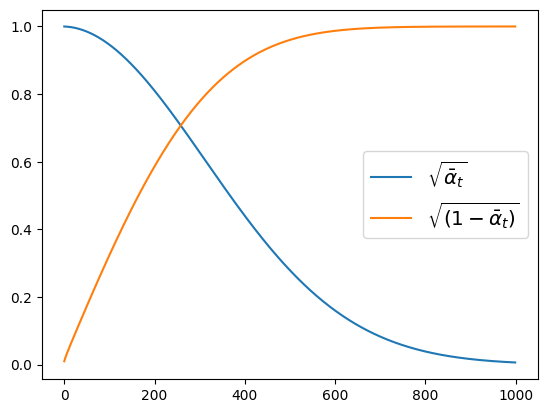

In [18]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");



Initially, the noisy x is mostly x (sqrt_alpha_prod ~= 1) but over time the contribution of x drops and the noise component increases.Unlike our linear mix of x and noise according to amount, this one gets noisy relatively quickly. We can visualize this on some data:


X shape torch.Size([8, 1, 28, 28])
Noisy X shape torch.Size([8, 1, 28, 28])


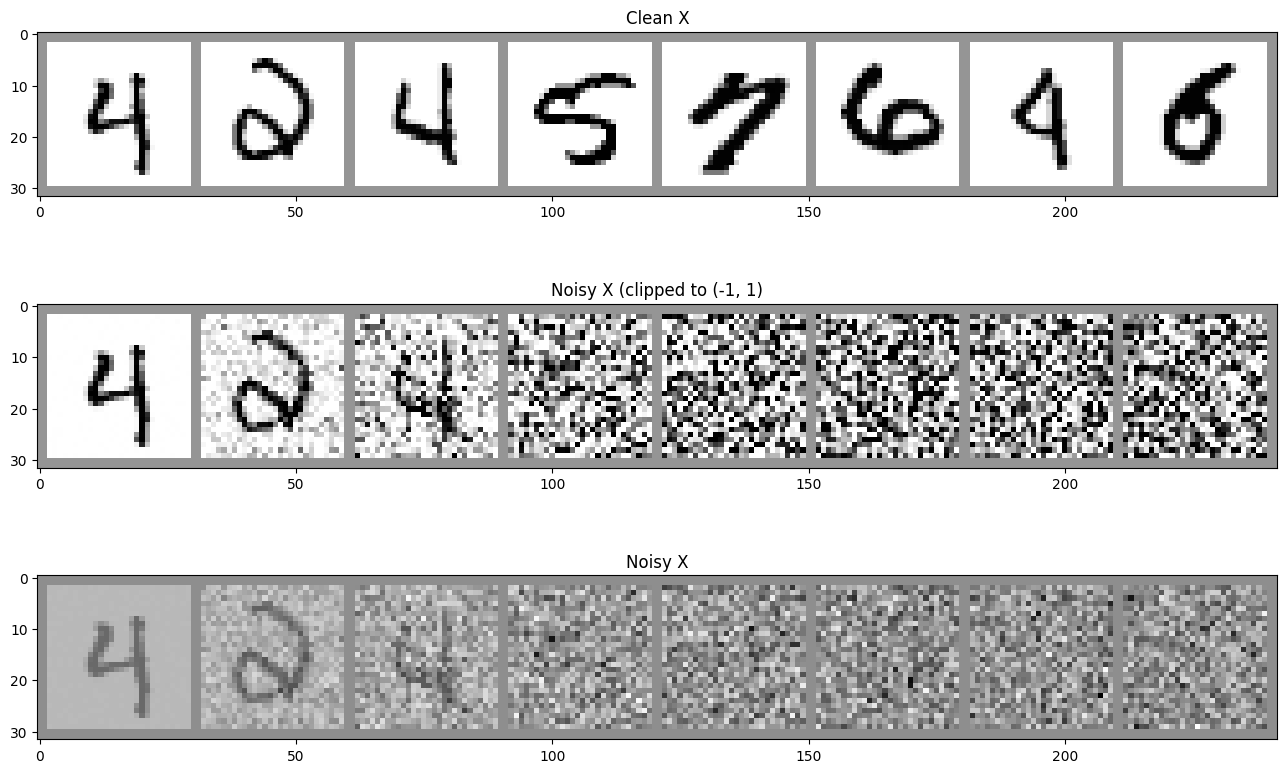

In [19]:
fig, axs = plt.subplots(3, 1, figsize=(16, 10))
xb, yb = next(iter(train_dataloader))
xb = xb.to(device)[:8]
xb = xb * 2. - 1.  # Map to (-1, 1) 
print('X shape', xb.shape)

# Show clean inputs
axs[0].imshow(torchvision.utils.make_grid(xb[:8])[0].detach().cpu(), cmap='Greys')
axs[0].set_title('Clean X')

# Add noise with scheduler
timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb)  # << NB: randn not rand
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print('Noisy X shape', noisy_xb.shape)

# Show noisy version (with and without clipping)
axs[1].imshow(torchvision.utils.make_grid(noisy_xb[:8])[0].detach().cpu().clip(-1, 1), cmap='Greys')
axs[1].set_title('Noisy X (clipped to (-1, 1)')
axs[2].imshow(torchvision.utils.make_grid(noisy_xb[:8])[0].detach().cpu(), cmap='Greys')
axs[2].set_title('Noisy X');

The noise added by the DDPM paper and if we compare it with our own one, the noise added by the DDPM is the Gaussian noise (mean of 0, s.d 1 from torch.randn) rather than the uniform noise that we added for the corruption process in our case.

#### Training Objective
In our minimalist model, we tried to denoise the image, however, in DDPM and various other models, the model predicts the noise that is used in the corruption process.

`noise = torch.randn_like(xb)` # << NB: randn not rand


`noisy_x = noise_scheduler.add_noise(x, noise, timesteps)`


`model_prediction = model(noisy_x, timesteps).sample`


`loss = mse_loss(model_prediction, noise)`# noise as the target



#### Timestamp Conditioning
The UNet2DModel takes both the x and the timestamp. The x input acts as an embedding and then acts as a input for the model in a number of places.
In theory if we provide only the noise, then the model will perform better, as its also possible for the model to work without the timestamp conditioning, it seems helps in the performance and mostly implementation include it in the current literature.

#### Sampling
The noise estimates present in the noisy input, how we generate the new images ?
We could feed in the pure noise, we think that it will produce the desired image in one step. As mentioned earlier it does not work well as we did in the above experimentation. A workaround is if we take small steps based on the model predictions, iteratively removing small portion of noise at a given time.
How these steps are taken ? Well mainly its depends on:
- What the length in time of a step ? In other words, what noise schedule you will have to select ?

- Do you, like DDPM, DDIM, and many others, solely utilize the model's most recent prediction to guide the update step? Do you evaluate the model numerous times to estimate higher-order gradients for a larger, more accurate step (higher-order approaches and some discrete ODE solvers)? Or do you preserve a history of past forecasts to attempt to better inform the current update step (linear multi-step and ancestral samplers)?

- Do you throw in additional noise (also termed churn) to add more stochasticity (randomness) to the sampling process, or do you leave it totally deterministic? Many samplers handle this via a parameter (such as 'eta' for DDIM samplers) so that the user can pick.